<a href="https://colab.research.google.com/github/HalyshAnton/WINSTARS.AI-task/blob/main/task1/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

## Importing Required Libraries
This section imports necessary libraries such as OpenCV, NumPy, PyTorch, and scikit-learn.

In [22]:
import cv2
import numpy as np
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from abc import ABC, abstractmethod
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

## Loading the MNIST Dataset
Using torchvision to download and load the MNIST dataset. The dataset consists of handwritten digits (0-9).

In [12]:
transform = torchvision.transforms.ToTensor()

dataset = torchvision.datasets.MNIST(root='.data/', download=True, transform=transform)

### Dataset Format Issue: PyTorch vs. Scikit-Learn

When working with the MNIST dataset, different machine learning models require different data formats:

- **PyTorch models** expect a dataset consisting of **pairs**: `(image, label)`, which allows easy integration with PyTorch's `DataLoader`.
- **Random Forest (Scikit-Learn)** requires separate **NumPy arrays**: `X` (features) and `y` (labels) to fit the model.

To maintain consistency across different models, I decided to use **Scikit-Learn style training**, where we explicitly separate images (`X`) and labels (`y`). This approach ensures:

1. **Unified Data Handling** – Both PyTorch and Scikit-Learn models can access the data easily.
2. **Better Compatibility** – Traditional machine learning models (like Random Forest) work naturally with NumPy arrays.
3. **Easier Preprocessing** – Standard transformations (e.g., normalization, reshaping) can be applied to `X` before feeding it into different models.

By structuring the dataset this way, we make it more adaptable for experimentation with both deep learning and classical machine learning techniques.


In [13]:
X = []
y = []

for img, label in dataset:
    img = img.numpy()

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((60000, 1, 28, 28), (60000,))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=10_000,
                                                    stratify=y,
                                                    random_state=42)

## Model Classes: Design and Structure

Each model in this project follows a **Scikit-Learn style API**, meaning it includes:

- **`train(X, y)` method** – Trains the model using the provided dataset.
- **`predict(X)` method** – Returns probability distributions instead of direct class labels.
- **preprocessing methods** - unique for each model

### Why Return Probabilities Instead of Labels?
Instead of returning only the predicted labels, the `predict` method provides a **probability distribution** over all possible classes. This approach has several advantages:

1. **More Information** – Instead of just saying "this is a 3," we can see how confident the model is about its prediction.
2. **Thresholding Flexibility** – Users can apply custom decision rules based on confidence levels.
3. **Better Interpretability** – Useful for applications like uncertainty estimation and ensemble learning.

### Model-Specific Preprocessing

Each model applies its own preprocessing steps to ensure the input data is correctly formatted for training and inference:

- **Random Forest**: Flattens each image into a **1D vector of 784 features** (`28 × 28` pixels) to match the expected input format for traditional machine learning models.
- **Feedforward Neural Network**: Flattens the image into a **1D tensor of 784 elements** and converts it to `float32` for compatibility with PyTorch models.
- **Convolutional Neural Network**: Converts the image into a **3D tensor of shape `(1, 28, 28)`**, preserving the spatial structure needed for convolutional layers.

These preprocessing steps ensure that each model receives data in the format it expects, improving training efficiency and accuracy.



In [15]:
class MnistClassifierInterface(ABC):
    @abstractmethod
    def train(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X):
        pass

In [16]:
class MnistRandomForest(MnistClassifierInterface):
    def __init__(self, **kwargs):
        self.model = RandomForestClassifier()

    def train(self, X_train, y_train):
        X_prep = self.__preprocess(X_train)

        self.model.fit(X_prep, y_train)

    def predict(self, X):
        X_prep = self.__preprocess(X)

        return self.model.predict_proba(X_prep)

    @staticmethod
    def __preprocess(X):
        return X.reshape(-1, 28*28)

In [17]:
class MnistFeedForward(MnistClassifierInterface):
    def __init__(self, **kwargs):
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.epochs = kwargs.get('epochs', 10)
        self.batch_size = kwargs.get('batch', 32)

        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=kwargs.get('lr', 1e-2)
                                          )

    def train(self, X_train, y_train):
        X_prep = self.__preprocess(X_train)

        dataset = list(zip(X_prep, y_train))
        dataloader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=self.batch_size,
                                                 shuffle=True
                                                 )

        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for X_batch, y_batch in dataloader:
                y_batch = y_batch.to(self.device)

                y_pred = self.model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()


    def predict(self, X):
        X_prep = self.__preprocess(X)
        X_prep = X_prep.to(self.device)

        self.model.eval()
        with torch.no_grad():
            return F.softmax(self.model(X_prep), dim=-1).cpu().numpy()

    def __preprocess(self, X):
        return torch.tensor(X.reshape(-1, 28*28),
                            dtype=torch.float32,
                            device=self.device
                            )

In [18]:
class MnistCNN(MnistClassifierInterface):
    def __init__(self, **kwargs):
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.epochs = kwargs.get('epochs', 10)
        self.batch_size = kwargs.get('batch', 32)

        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=kwargs.get('lr', 1e-4)
                                          )

    def train(self, X_train, y_train):
        X_prep = self.__preprocess(X_train)

        dataset = list(zip(X_prep, y_train))
        dataloader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=self.batch_size,
                                                 shuffle=True
                                                 )

        loss_fn = nn.CrossEntropyLoss()


        self.model.train()
        for _ in range(self.epochs):
            for X_batch, y_batch in dataloader:
                y_batch = y_batch.to(self.device)

                y_pred = self.model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()


    def predict(self, X):
        X_prep = self.__preprocess(X)
        X_prep = X_prep.to(self.device)

        self.model.eval()
        with torch.no_grad():
            return F.softmax(self.model(X_prep), dim=-1).cpu().numpy()

    def __preprocess(self, X):
        return torch.tensor(X,
                            dtype=torch.float32,
                            device=self.device
                            )

In [19]:
class MnistClassifier:
    def __init__(self, algorithm, **kwargs):
        if algorithm == 'rf':
            self.model = MnistRandomForest(**kwargs)
        elif algorithm == 'nn':
            self.model = MnistFeedForward(**kwargs)
        elif algorithm == 'cnn':
            self.model = MnistCNN(**kwargs)
        else:
            raise ValueError(f'algorithm should be one of (rf, nn, cnn) not {algorithm}')

    def train(self, X, y):
        self.model.train(X, y)

    def predict(self, X):
        return self.model.predict(X)

## Training and Evaluation

After training and testing the models, their accuracy scores indicate the following ranking from worst to best:

1. **Random Forest (RF) – 96.7%**
   - Performs the worst, likely due to its inability to capture spatial relationships in images.  
   - Since it processes flattened images, it loses important structural information.  

2. **Feedforward Neural Network (NN) – 97.3%**
   - Outperforms the random forest, suggesting that decision trees cannot effectively handle certain digit patterns.    

3. **Convolutional Neural Network (CNN) – 98.8%**  
   - Achieves the highest accuracy by leveraging spatial hierarchies and local patterns in images.  
   - Well-suited for digit classification due to its ability to automatically extract relevant features.  

This ranking highlights the advantage of CNNs in image classification while also showing that traditional machine learning approaches like Random Forest can still be competitive with proper tuning.  


In [20]:
model_rf = MnistClassifier('rf')
model_nn = MnistClassifier('nn')
model_cnn = MnistClassifier('cnn')

models = [model_rf, model_nn, model_cnn]

for model in models:
    model.train(X_train, y_train)

RandomForest	96.7%


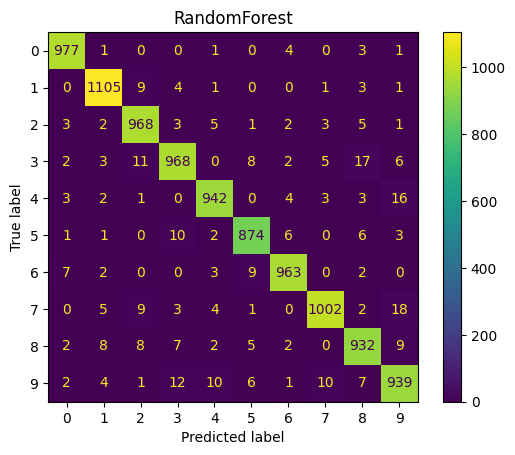

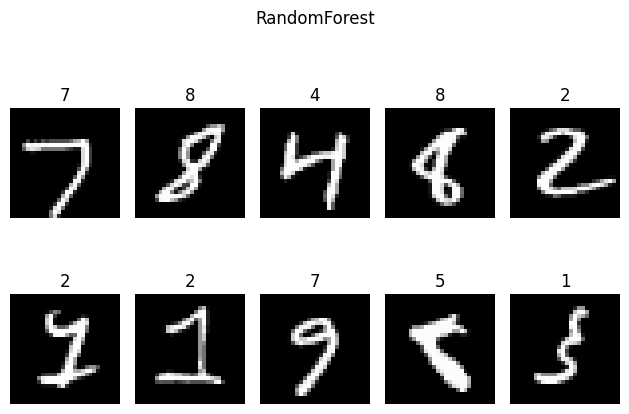

FeedForward	97.3%


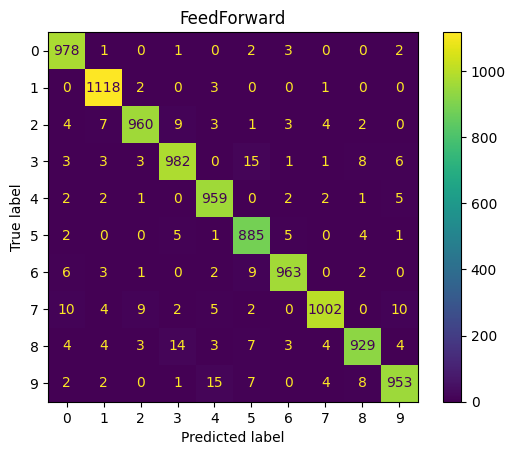

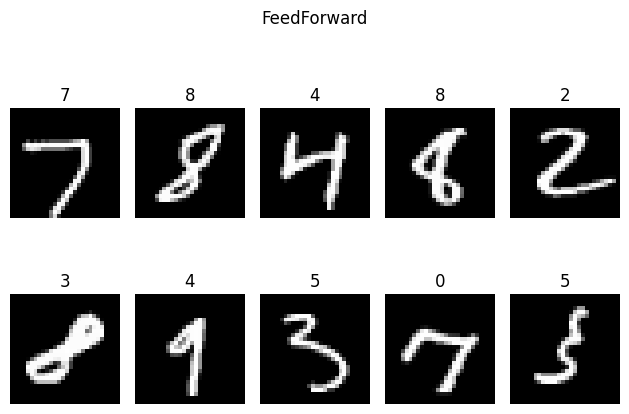

CNN	98.7%


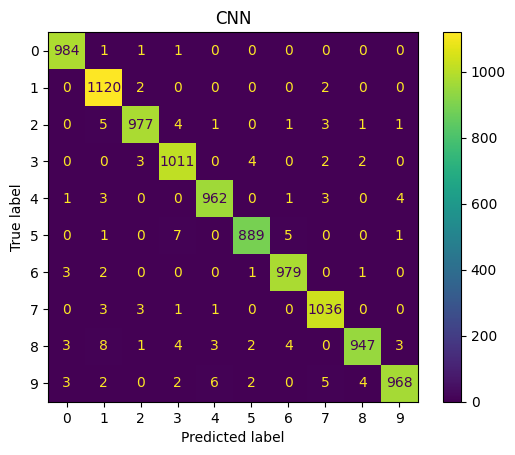

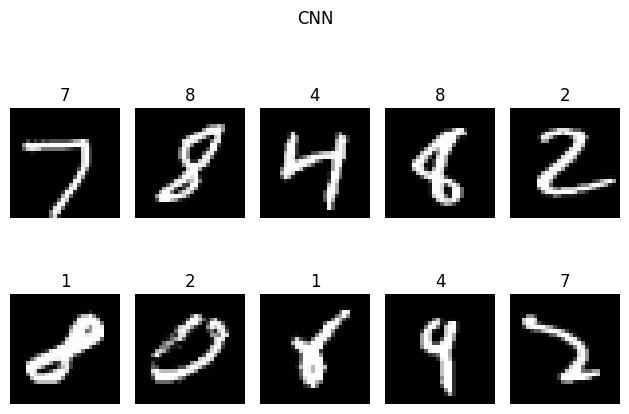

In [23]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay


for algorithm, model in zip(('RandomForest', 'FeedForward', 'CNN'), models):
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)

    acc = accuracy_score(y_test, y_pred) * 100
    print(f'{algorithm}\t{acc:0.1f}%')

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{algorithm}")
    plt.show()

    X_good = X_test[y_test == y_pred][:5]
    X_bad = X_test[y_test != y_pred][:5]

    for row, sample in enumerate((X_good, X_bad)):
        labels = model.predict(sample).argmax(axis=-1)

        for i, (img, label) in enumerate(zip(sample, labels), start=1):
            plt.subplot(2, 5, 5*row+i)
            plt.title(f"{label}")
            plt.imshow(img[0], cmap='gray')
            plt.axis('off')

    plt.suptitle(f"{algorithm}")
    plt.tight_layout()

    plt.show()


## Improving Feedforward Model with NU Moments on MNIST

In an effort to improve the performance of a feedforward neural network (FNN) on the MNIST dataset, I decided to try NU Moments as a preprocessing technique. However, despite the intention to enhance the model, this approach ended up performing worse than simply flattening the images.





### Why Flattening Performed Better
- Flattening preserves all pixel information (28x28 grid as a 784-element vector).
- HU Moments, a subset of normalized central moments, are designed to capture global shape features, such as rotation, scaling, and translation invariance.
- Handwritten digits in MNIST, however, have a lot of variation in style, thickness, and curve, which HU Moments might not capture well.
- The moment-based features tend to focus more on overall shapes rather than local details or spatial relationships, which are critical in distinguishing similar-looking digits like "3" and "8."
- I experimented with different model architectures specifically tailored for HU Moments but could not achieve more than 30% accuracy.

In [24]:
class MnistFeedForwardTest(MnistClassifierInterface):
    def __init__(self, **kwargs):
        self.preprocessing = kwargs.get('preprocessing', 'flat')

        self.model = self.__get_model(self.preprocessing)

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.preprocessing = kwargs.get('preprocessing', 'flat')

        self.epochs = kwargs.get('epochs', 10)
        self.batch_size = kwargs.get('batch', 32)

        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=kwargs.get('lr', 1e-2)
                                          )

    def train(self, X_train, y_train):
        X_prep = self.__preprocess(X_train)

        dataset = list(zip(X_prep, y_train))
        dataloader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=self.batch_size,
                                                 shuffle=True
                                                 )

        loss_fn = nn.CrossEntropyLoss()

        losses = []
        self.model.train()
        for _ in range(self.epochs):
            loss_ = []
            for X_batch, y_batch in dataloader:
                y_batch = y_batch.to(self.device)

                y_pred = self.model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                loss_.append(loss.item())
            losses.append(np.mean(loss_))

        return losses

    def predict(self, X):
        X_prep = self.__preprocess(X)
        X_prep = X_prep.to(self.device)

        self.model.eval()
        with torch.no_grad():
            return F.softmax(self.model(X_prep), dim=-1).cpu().numpy()

    def __preprocess(self, X):
        if self.preprocessing == 'flat':
            return torch.tensor(X.reshape(-1, 28*28),
                                dtype=torch.float32,
                                device=self.device
                                )

        X = X.reshape(-1, 28, 28, 1)
        X = X * 255
        X = X.astype('uint8')
        X_prep = [self.__get_hu(img) for img in X]

        return torch.tensor(X_prep,
                            dtype=torch.float32,
                            device=self.device
                            )

    @staticmethod
    def __get_hu(img):
        _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        moments = cv2.moments(img)
        hu_moments = cv2.HuMoments(moments)

        hu_moments = np.array(hu_moments)
        features = -np.sign(hu_moments) * np.log(np.abs(hu_moments) + 1e-6)
        features /= 6 # scale features from range [-6, 6] to [-1, 1]

        return features.reshape(-1)

    @staticmethod
    def __get_model(prep):
        if prep == 'flat':
            return nn.Sequential(
                nn.Linear(784, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, 32),
                nn.ReLU(),
                nn.Linear(32, 10)
            )
        else:
            return nn.Sequential(
                nn.Linear(7, 20),
                nn.ReLU(),
                nn.Linear(20, 10),
                nn.ReLU(),
                nn.Linear(10, 10)
            )

In [25]:
model_flat = MnistFeedForwardTest(preprocessing = 'flat')
model_hu = MnistFeedForwardTest(preprocessing = 'hu')

loss_flat = model_flat.train(X_train, y_train)
loss_hu = model_hu.train(X_train, y_train)

<ipython-input-24-1effdd0f5fda>:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X_prep,


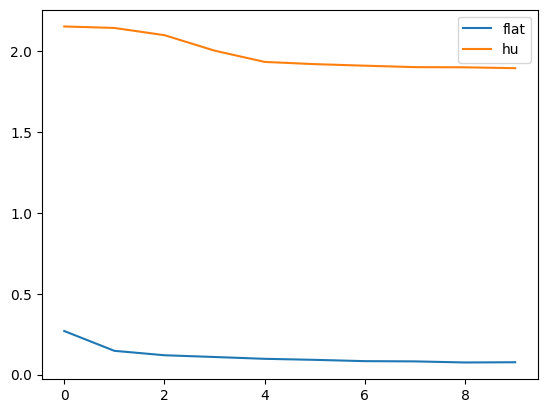

In [26]:
plt.plot(loss_flat, label='flat')
plt.plot(loss_hu, label='hu')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score


y_pred_flat = model_flat.predict(X_test)
acc = accuracy_score(y_test, y_pred_flat.argmax(axis=-1))
print(f'flat\t{acc*100:0.1f}%')

y_pred_hu = model_hu.predict(X_test)
acc = accuracy_score(y_test, y_pred_hu.argmax(axis=-1))
print(f'hu\t{acc*100:0.1f}%')

flat	97.5%
hu	31.2%
